# Bayesian Inference


To get our baseline inferences, we should find the probablities of of each combination of cards.

In [1]:
import random
import math
# Baye's Theorem
# P(A|B) = P(B|A)*P(A) / P(B)

SUITS = 4
TOTAL_CARDS = 40
HAND = 10
COMMON_CARDS = 12
COMMON_SUIT = "Spades"
CARDS_REMAINING = TOTAL_CARDS - COMMON_CARDS
PROBABILITY_COMMON = 1/SUITS

In [2]:
def compute_probabilities_range(suit_observations):
    r = {}
    for observation in suit_observations:
        # Number of total hands
        total_hands = math.comb(TOTAL_CARDS, COMMON_CARDS)
        remaining_hand = HAND - observation

        # Number of ways to get [obs] spades in hand assuming Spades is common suit
        # N Spades | Spades is common suit
        # First part is the # combinations of the common suit, second part is the rest of the hand
        ways_obs_spades_common = math.comb(COMMON_CARDS, observation) * math.comb(CARDS_REMAINING, remaining_hand)

        # Number of ways to get [obs] spades in hand assuming Spades is NOT the common suit
        # N Spades | Spades is not common suit
        # This is assuming that spades is 10 cards
        ways_obs_spades_10 = math.comb(10, observation) * math.comb(TOTAL_CARDS - 10, remaining_hand)

        # Number of ways to get [obs] spades in hand assuming Spades is NOT the common suit
        # N Spades | Spades is not common suit
        # This is assuming that spades is 8 cards
        ways_obs_spades_8 = math.comb(8, observation) * math.comb(TOTAL_CARDS - 8, remaining_hand)

        

        # Probability of [obs] Spades given Spades is common
        prob_obs_spades_common = ways_obs_spades_common / total_hands
        # Probability of [obs] Spades given Spades is not common (10 cards)
        prob_obs_spades_not_common_10 = ways_obs_spades_10 / total_hands
        # Probability of [obs] Spades given Spades is not common (8 cards)
        prob_obs_spades_not_common_8 = ways_obs_spades_8 / total_hands

        prob_obs_spades_not_common = prob_obs_spades_not_common_10 * 2/3 + prob_obs_spades_not_common_8 * 1/3


        prob_obs_spades = prob_obs_spades_common * 0.25 + prob_obs_spades_not_common_10 * 0.5 + prob_obs_spades_not_common_8 * 0.25
        prob_common_given_obs_spades = prob_obs_spades_common * PROBABILITY_COMMON / prob_obs_spades

        r[observation] = round(prob_common_given_obs_spades, 4)
    
    return r


In [3]:
import matplotlib.pyplot as plt

def plot_probabilities_range(results):
    x = list(results.keys())
    y = list(results.values())
    plt.figure(figsize=(12,6))
    plt.plot (x, y, marker = 'o', linestyle='-')
    for i, value in enumerate(y):
        plt.text(
            x[i],
            y[i] + 0.035,
            f'{value:.2f}',
            ha='center',
            va='bottom',
            fontsize=9,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
        )
    plt.xlabel('Number Spades in Starting Hand')
    plt.ylabel('Probability of Spades being the Common Suit')
    plt.title('Probability of Spades being the Common Suit given n Spades')
    plt.grid(True)
    plt.show()

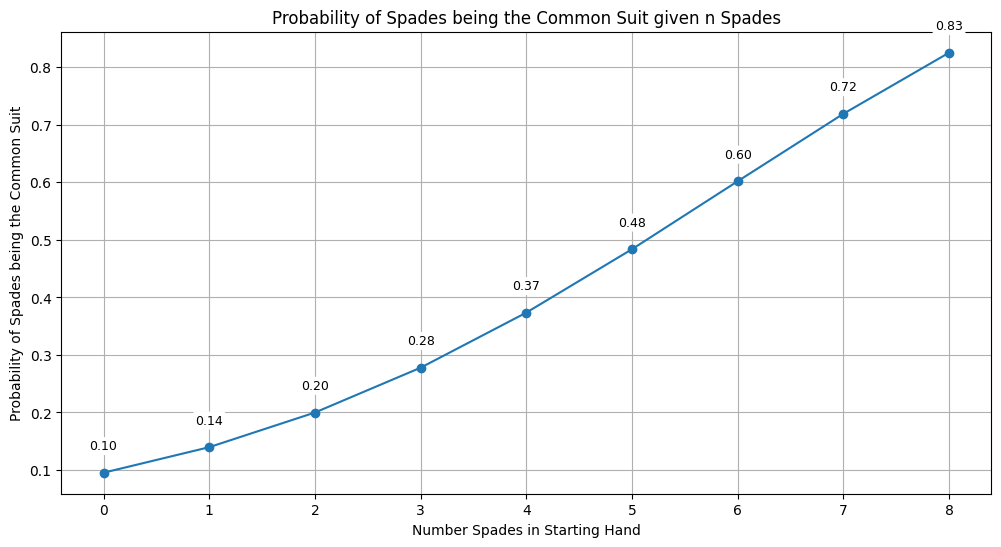

In [4]:
SPADES_OBSERVATIONS = range(0,9)

probabilities = compute_probabilities_range(SPADES_OBSERVATIONS)
plot_probabilities_range(probabilities)

# Game Engine

In [ ]:
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

class gameSpace:
    def __init__(self, players):
        self.players = []
        self.commonSuit = "Diamonds"
        self.goalSuit = "Hearts"
        self.cardDistributions = {"Spades" : 8, "Clubs" : 10, "Hearts" : 10, "Diamonds" : 12}
        self.players = players
        self.cards_per_player = 10

    def dealCards(self):
        for player_instance in self.players:
            player_instance.cards = {
                "Spades": 0,
                "Clubs": 0,
                "Hearts": 0,
                "Diamonds": 0,
            }

        deck = []
        for suit, count in self.cardDistributions.items():
            deck.extend([suit] * count)

        total_needed = self.cards_per_player * len(self.players)
        if total_needed > len(deck):
            raise ValueError("Not enough cards to deal 10 to each player.")

        random.shuffle(deck)

        for i in range(total_needed):
            suit = deck[i]
            self.players[i % len(self.players)].cards[suit] += 1

    def changeCommonSuit(self):
        suits = ['Spades', 'Clubs', 'Hearts', 'Diamonds']
        goalSuit = {"Spades" : "Clubs", "Clubs" : "Spades", "Hearts" : "Diamonds", "Diamonds" : "Hearts"}
        numCards = [8, 10, 10]
        self.commonSuit = random.choice(suits)
        self.goalSuit = goalSuit[self.commonSuit]


        self.cardDistributions[self.commonSuit] = 12
        suits.remove(self.commonSuit)

        for suit in suits:
            cards = random.choice(numCards)
            self.cardDistributions[suit] = cards
            numCards.remove(cards)


    def displayCards(self):
        print(f"Card distributions:")
        print(self.cardDistributions)
        print("Common Suit: ", self.commonSuit)
        print("Goal Suit: ", self.goalSuit)
        
        print("Player cards: ")
        for i in range(len(self.players)):
            print(f"player {i}: ", self.players[i].cards)

        print("\n-----------------------------------------------\n")

    def newGame(self):
        self.changeCommonSuit()
        self.dealCards()

    def calculateProbabilities(self):
        if not hasattr(self, "total_goal_guesses"):
            self.total_goal_guesses = 0
            self.correct_goal_guesses = 0
            self.games_played = 0

        goalSuitMap = {
            "Spades": "Clubs",
            "Clubs": "Spades",
            "Hearts": "Diamonds",
            "Diamonds": "Hearts",
        }

        for player_instance in self.players:
            max_count = max(player_instance.cards.values())
            top_suits = [
                suit for suit, count in player_instance.cards.items()
                if count == max_count
            ]

            if len(top_suits) != 1:
                continue

            assumed_common_suit = top_suits[0]
            guessed_goal_suit = goalSuitMap[assumed_common_suit]

            self.total_goal_guesses += 1
            if guessed_goal_suit == self.goalSuit:
                self.correct_goal_guesses += 1

        self.games_played += 1

        if self.total_goal_guesses == 0:
            return 0

        return self.correct_goal_guesses / self.total_goal_guesses

    def visualizeProbabilities(self, games_to_play):
        probabilities = []
        for _ in range(games_to_play):
            self.newGame()
            probabilities.append(self.calculateProbabilities())

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, games_to_play + 1), probabilities, label="Running probability")
        plt.xlabel("Games played")
        plt.ylabel("Probability of correct goal-suit guess")
        plt.title("Goal-suit guess probability over games")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        return probabilities
        
class player:
    def __init__(self):
        self.cards = {"Spades" : 0, "Clubs" : 0, "Hearts" : 0, "Diamonds" : 0}

In [ ]:
players = []
for i in range(4):
    players.append(player())


game = gameSpace(players)
game.visualizeProbabilities(10000)